In [23]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import os
import json
from pycocotools.coco import COCO

class BirdDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.img_ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        annotation_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(annotation_ids)

        boxes = []
        labels = []
        for annotation in annotations:
            xmin = annotation['bbox'][0]
            ymin = annotation['bbox'][1]
            width = annotation['bbox'][2]
            height = annotation['bbox'][3]
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(annotation['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define paths
root_train = '/home/radiologyy/Desktop/pythonProject/od/od_birds/bird detection.v5i.coco/train'
annotation_file_train = '/home/radiologyy/Desktop/pythonProject/od/od_birds/bird detection.v5i.coco/train/_annotations.coco.json'
root_test = '/home/radiologyy/Desktop/pythonProject/od/od_birds/bird detection.v5i.coco/test'
annotation_file_test = '/home/radiologyy/Desktop/pythonProject/od/od_birds/bird detection.v5i.coco/test/_annotations.coco.json'

# Create dataset and dataloaders
dataset = BirdDataset(root_train, annotation_file_train, get_transform(train=True))
dataset_test = BirdDataset(root_test, annotation_file_test, get_transform(train=False))

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Load a pre-trained model
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (bird) + background
model = get_model_instance_segmentation(num_classes)
model.to(device)

# Training loop
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item()}")

# Save the trained model
torch.save(model.state_dict(), 'fasterrcnn_bird_detector.pth')


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/radiologyy/anaconda3/envs/rsna39_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/radiologyy/anaconda3/envs/rsna39_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.07989921420812607
Epoch 2, Loss: 0.04275832325220108
Epoch 3, Loss: 0.13227885961532593
Epoch 4, Loss: 0.1011510044336319
Epoch 5, Loss: 0.23617635667324066
Epoch 6, Loss: 0.16935327649116516
Epoch 7, Loss: 0.11186210066080093
Epoch 8, Loss: 0.08596884459257126
Epoch 9, Loss: 0.1738729625940323
Epoch 10, Loss: 0.06693878024816513


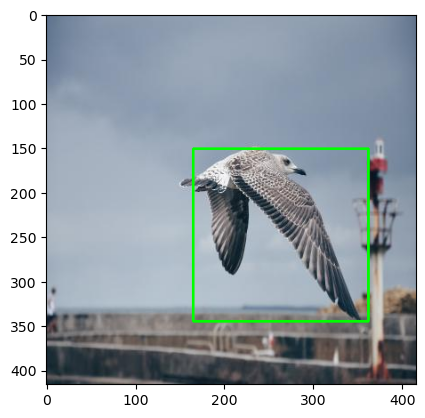

In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

model.eval()
image = Image.open('/home/radiologyy/Desktop/pythonProject/od/od_birds/bird detection.v5i.coco/test/des-recits-YkYSChy5RU4-unsplash_jpg.rf.fe5433c209c61b28c2ea32c0ec5c6187.jpg').convert("RGB")
image_tensor = T.ToTensor()(image).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(image_tensor)

boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()

# Convert image to OpenCV format for visualization
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

for i, box in enumerate(boxes):
    if scores[i] > 0.5:  # Only keep high-confidence detections
        cv2.rectangle(image_cv, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.show()